### PSC overexpression example

This notebook prepares a dataset with hundreds of individual overexpression experiments applied to pluripotent stem cells ([Nakatake et al 2020](https://www.sciencedirect.com/science/article/pii/S2211124720306082)). This choice of dataset is meant to be an easy starting point: the time-scale (48 hours) is fairly short-term, the cell state (pluripotency) is well studied,  and the perturbations are numerous (714 genes including 481 TF's). The dataset is also small (~1k samples) so testing/debugging is fast. 

The data contain both microarray and RNA-seq measurements, but these have already been effectively integrated by the authors using a strategy akin to quantile normalization. There are missing values marked -9999, which include genes missing from microarrays and outlying measurements censored by the creators. For now, missing values are being filled in with control gene expression. There are three types of negative control *samples*, labeled "control", "emerald", and "CAG-rtTA35-IH". We use mostly "control". 

Here we tidy the PSC overexpression dataset and carry out a simple exploration in scanpy. (It's not single cell data but scanpy is clearly a useful place to start.) 

In [23]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import sys
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
from scipy.stats import spearmanr as spearmanr
# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# I prefer to specify the working directory explicitly.
os.chdir("/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/perturbations/")

### Reshape the data

In [26]:
expression_quantified = pd.read_csv("not_ready/ko_esc/CREST_06162021.txt", 
                              delimiter="\t",
                              index_col=0, 
                              header=0, 
                              comment = '!')    
gene_metadata   = expression_quantified.iloc[:,-4:]
expression_quantified = expression_quantified.iloc[:, 0:-4].T
sample_metadata = pd.DataFrame(columns = ["perturbation"], 
                               index = expression_quantified.index,
                               data = [re.sub("\..", "", g) for g in expression_quantified.index])

expression_quantified = sc.AnnData(expression_quantified, 
                             var = gene_metadata,
                             obs = sample_metadata)
expression_quantified.raw = expression_quantified.copy()

In [27]:
# Document controls with weird names
controls = ("Emerald", "Control", "CAG-rtTA35-IH")
for c in controls:
    assert c in sample_metadata['perturbation'].unique() 
expression_quantified.obs["is_control"] = expression_quantified.obs['perturbation'].isin(controls)

### Count and impute missing entries

Most but not all of the missingness is due to microarrays capturing fewer genes than RNA-seq.

Some is due to Nakatake et al. removing outliers. 

In [28]:
missing = expression_quantified.X==-9999
expression_quantified.obs["fraction_missing"] = missing.mean(axis=1)
expression_quantified.var["fraction_missing"] = missing.mean(axis=0)
controlIndex = expression_quantified.obs.index=="Control"
for i in range(len(expression_quantified.obs.index)):
    missing_i = np.squeeze(expression_quantified[i,:].X==-9999)
    expression_quantified.X[i,missing_i] = expression_quantified.X[controlIndex,missing_i]
pd.DataFrame(expression_quantified.obs.fraction_missing.value_counts())

,fraction_missing
0.000000,844
0.192786,149
0.000040,4
0.000279,2
0.000239,2
0.000159,2
0.001993,1
0.000917,1
0.000359,1
0.000120,1


In [29]:
pd.DataFrame(expression_quantified.var.fraction_missing.value_counts())

,fraction_missing
0.000000,20032
0.151186,4804
0.000988,214
0.152174,33
0.001976,7


In [30]:
expression_quantified.obs

,perturbation,is_control,fraction_missing
AATF,AATF,False,0.000000
AATF.1,AATF,False,0.000000
ALX3,ALX3,False,0.000000
ALX3.1,ALX3,False,0.000000
ALX4,ALX4,False,0.000000
...,...,...,...
ZNF780A,ZNF780A,False,0.192786
ZNF780A.1,ZNF780A,False,0.192786
ZSCAN5A,ZSCAN5A,False,0.192786
ZSCAN5A.1,ZSCAN5A,False,0.192786


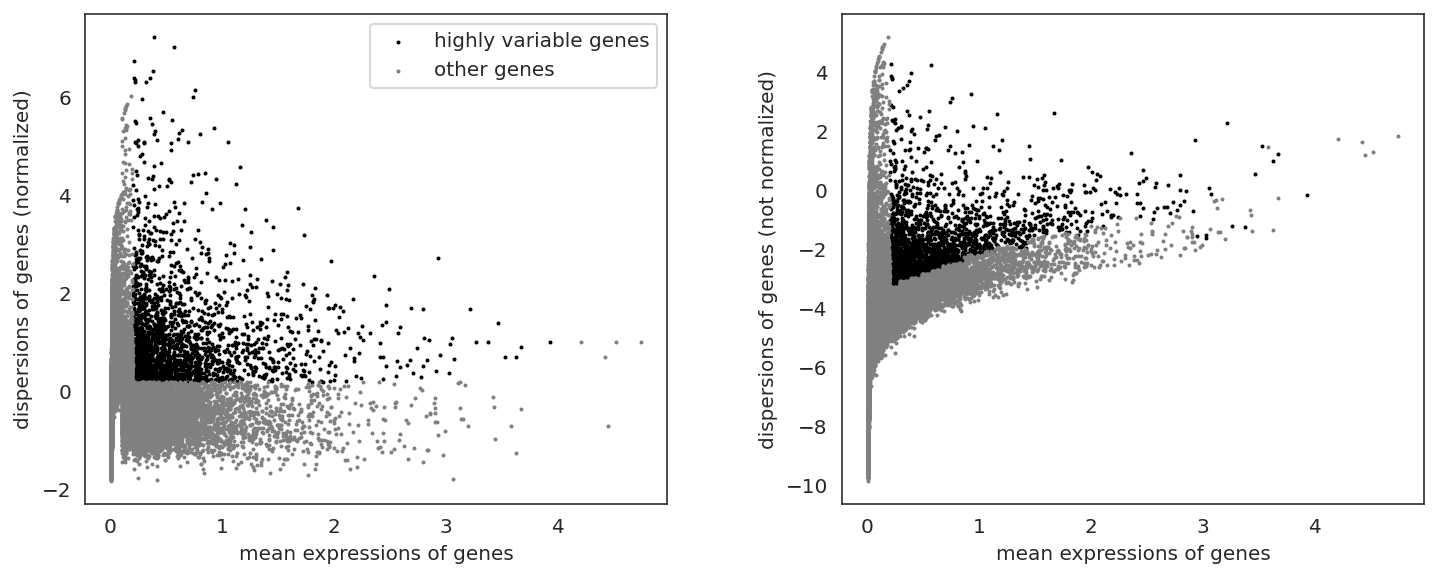

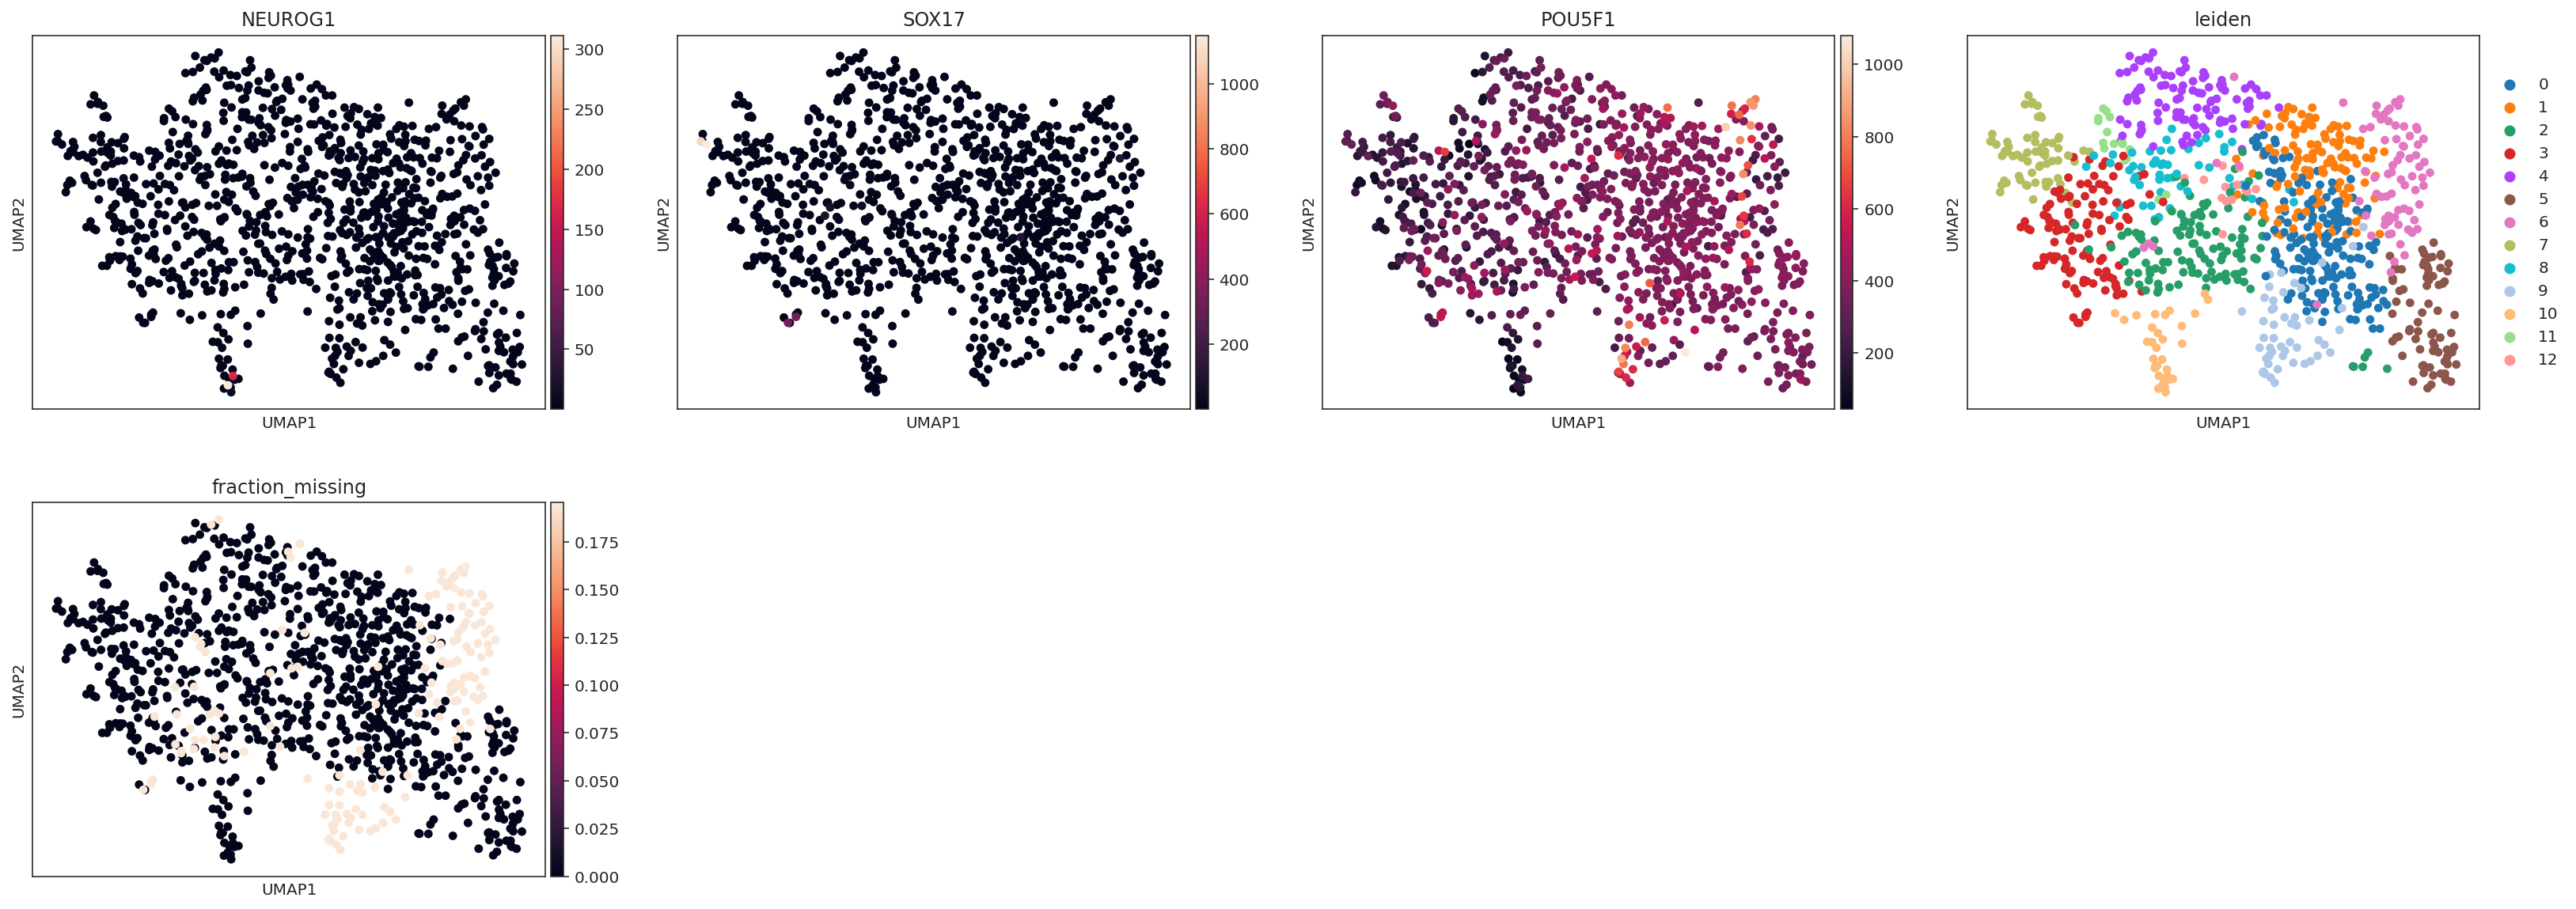

In [31]:
sc.pp.normalize_total(expression_quantified, target_sum=1e4)
sc.pp.log1p(expression_quantified)
sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=100)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []
sc.tl.leiden(expression_quantified)
sc.pl.umap(expression_quantified, color = ["NEUROG1", "SOX17", "POU5F1", "leiden", "fraction_missing"])
# Due to the small number of samples, ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
expression_quantified.obs["fake_cluster"]="all_one_cluster"
expression_quantified.obs.fake_cluster = expression_quantified.obs.fake_cluster.astype("category")
expression_quantified.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

For quick software tests, we also take some data with as few genes as possible (just those that are perturbed and measured).

In [32]:
perturbed_genes = set(list(expression_quantified.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(expression_quantified.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(expression_quantified.var.index)
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
genes_keep = expression_quantified.var.index[expression_quantified.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
expression_quantified_orig = expression_quantified
# Nakatake data final form
expression_quantified = expression_quantified_orig[:,list(genes_keep)]
expression_quantified.uns["perturbed_and_measured_genes"] = list(perturbed_and_measured_genes)
expression_quantified.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)

expression_quantified = ingestion.describe_perturbation_effect(expression_quantified, "overexpression")


These genes were perturbed but not measured:
{'T', 'DUX4'}


In [33]:
try:
    os.makedirs("perturbations/nakatake")
except FileExistsError:
    pass
expression_quantified.write_h5ad("perturbations/nakatake/test.h5ad")


In [34]:
expression_quantified

AnnData object with n_obs × n_vars = 1012 × 2603
    obs: 'perturbation', 'is_control', 'fraction_missing', 'leiden', 'fake_cluster', 'expression_level_after_perturbation', 'perturbation_type'
    var: 'Symbol', 'Gene title', 'GENBANK', 'Entrez', 'fraction_missing', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'fake_cluster_colors', 'perturbed_and_measured_genes', 'perturbed_but_not_measured_genes'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [35]:
software_test_data

AnnData object with n_obs × n_vars = 1012 × 508
    obs: 'perturbation', 'is_control', 'fraction_missing', 'leiden', 'fake_cluster'
    var: 'Symbol', 'Gene title', 'GENBANK', 'Entrez', 'fraction_missing', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'fake_cluster_colors', 'perturbed_and_measured_genes', 'perturbed_but_not_measured_genes'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'